## Setup and Dependencies

In [ ]:
# @title Mount Google Drive and Install Dependencies
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages with specific versions
!pip uninstall -y bitsandbytes accelerate transformers peft tokenizers
!pip install -q torch==2.2.0 accelerate==0.27.2
!pip install -q tokenizers==0.13.3
!pip install -q bitsandbytes==0.42.0
!pip install -q transformers==4.34.1 peft==0.5.0
!pip install -q datasets wandb deepspeed

Found existing installation: bitsandbytes 0.42.0
Uninstalling bitsandbytes-0.42.0:
  Successfully uninstalled bitsandbytes-0.42.0
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: transformers 4.34.1
Uninstalling transformers-4.34.1:
  Successfully uninstalled transformers-4.34.1
Found existing installation: peft 0.5.0
Uninstalling peft-0.5.0:
  Successfully uninstalled peft-0.5.0
Found existing installation: tokenizers 0.14.1
Uninstalling tokenizers-0.14.1:
  Successfully uninstalled tokenizers-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.4.1 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.17.3 which is incompatible.
diffusers 0.32.2 requires huggingface-hub>=0.23.2, but you have huggingface-hub 0.17.3 which is incompatib

In [ ]:
# Force correct CUDA setup for bitsandbytes
import os
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
!ldconfig /usr/local/cuda/lib64 || tru

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is

In [ ]:
# Verify installation
try:
    import torch
    import bitsandbytes as bnb
    import tokenizers
    import transformers
    from transformers.utils import is_bitsandbytes_available
    print(f"Bitsandbytes version: {bnb.__version__}")
    print(f"Tokenizers version: {tokenizers.__version__}")
    print(f"Transformers version: {transformers.__version__}")
    print(f"Is bitsandbytes properly available: {is_bitsandbytes_available()}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")
except Exception as e:
    print(f"Error in verification: {e}")

# Restart runtime - uncomment this if still having issues after running this cell
# exit()
# exit()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

Bitsandbytes version: 0.42.0
Tokenizers version: 0.14.1
Transformers version: 4.34.1
Is bitsandbytes properly available: True
CUDA available: True
CUDA version: 12.1
CUDA device: NVIDIA A100-SXM4-40GB


In [ ]:
# Import required libraries
import os
import gc
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from datasets import load_dataset, DatasetDict
from accelerate import Accelerator
from transformers import BitsAndBytesConfig
from google.colab import userdata
import wandb

# Set environment variables for memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Reset CUDA to clear memory
torch.cuda.empty_cache()
gc.collect()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

398

In [ ]:
# @title Configure Paths and Model
# Define model name and checkpoint path
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"  # Upgraded to Instruct version
CHECKPOINT_DIR = "/content/drive/MyDrive/improved-mistral-ef-checkpoints"
FINAL_OUTPUT_DIR = "/content/drive/MyDrive/improved-mistral-ef-final"

# Create directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(FINAL_OUTPUT_DIR, exist_ok=True)

# Access HF_TOKEN from Colab secrets or set manually
try:
    os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
    print("Successfully retrieved HF_TOKEN from Colab secrets")
except:
    print("Could not retrieve HF_TOKEN from Colab secrets")
    # Uncomment and replace with your token if needed
    # os.environ["HF_TOKEN"] = "your_token_here"

Successfully retrieved HF_TOKEN from Colab secrets


In [ ]:
# @title Clone the Repository with Training Data
if not os.path.exists('Carbon-EF'):
    !git clone https://github.com/Sbursu/Carbon-EF.git
%cd Carbon-EF

/content/Carbon-EF


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Dataset statistics:
  train: 3884 examples
  validation: 972 examples
  test: 485 examples

Sample example:
[INST] What is the emission factor for Biomass Energy in Germany? [/INST] The emission factor for Biomass Energy in Germany is 87.7 kg CO2e/kWh. This data is sourced from GREET.


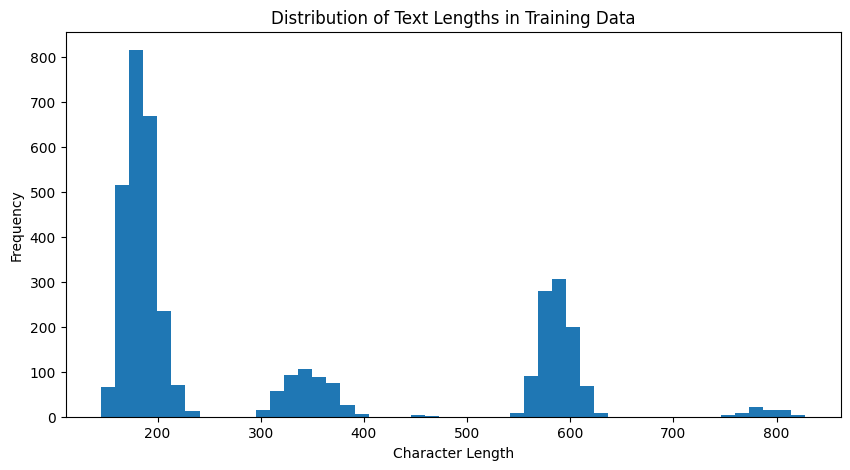

In [ ]:
# @title Load and Prepare Data
# Load and process data with enhanced quality checks
try:
    # Load and process data
    dataset = load_dataset('json', data_files={
        'train': 'training/data/instructions_train.json',
        'validation': 'training/data/instructions_val.json',
        'test': 'training/data/instructions_test.json'
    })

    # Enhance the instruction format with better prompting
    def format_instruct(example):
        # Extract any available geographic or sector information
        geography = example.get('geography', '')
        sector = example.get('sector', '')
        additional_context = ''

        if geography and sector:
            additional_context = f" Consider {sector} in {geography}."
        elif geography:
            additional_context = f" Consider regional factors for {geography}."
        elif sector:
            additional_context = f" Consider industry standards for {sector}."

        # Create a more structured prompt
        instruction = example['instruction']
        output = example['output']

        return {
            'text': f"[INST] {instruction}{additional_context} [/INST] {output}"
        }

    dataset = dataset.map(format_instruct, remove_columns=['instruction', 'output'])

    # Enhanced data visualization and statistics
    print(f"Dataset statistics:")
    for split in dataset:
        print(f"  {split}: {len(dataset[split])} examples")

    # Show sample and stats
    print("\nSample example:")
    print(dataset['train'][0]['text'])

    # Analyze data distributions
    train_lengths = [len(example['text']) for example in dataset['train']]
    plt.figure(figsize=(10, 5))
    plt.hist(train_lengths, bins=50)
    plt.title('Distribution of Text Lengths in Training Data')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')
    plt.savefig('/content/drive/MyDrive/improved-mistral-ef-checkpoints/data_distribution.png')

except Exception as e:
    print(f"Error: {e}")
    raise RuntimeError("Data processing failed - check file paths and formats")

In [ ]:
# @title Initialize Model and Tokenizer with Improved Settings
# @title Load Model and Tokenizer
# Define cache directory
import os
model_cache_dir = "/tmp/mistral_cache"
os.makedirs(model_cache_dir, exist_ok=True)

# Configure 8-bit quantization instead of 4-bit for better compatibility
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,      # Changed from 4-bit to 8-bit
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8"
)

print(f"Loading base model {MODEL_NAME}...")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU information
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Initialize tokenizer with optimized settings and custom cache
try:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=True,
        cache_dir=model_cache_dir
    )
    print("Tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Trying alternative approach with use_fast=False")
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=False,
        cache_dir=model_cache_dir
    )
    print("Slow tokenizer loaded successfully as fallback")

# Add pad token if needed
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token to eos_token")

# Load the base model with improved memory management and error handling
try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        token=os.environ.get("HF_TOKEN"),
        cache_dir=model_cache_dir,
        max_memory={0: "24GiB", "cpu": "30GiB"},  # Optimized for A100
        sliding_window=4096  # Explicitly set sliding window size
    )
    print(f"Base model loaded successfully with 8-bit quantization")
except Exception as e:
    print(f"Error loading with quantization: {e}")
    print("Falling back to FP16 without quantization")

    # Fallback to regular fp16 without quantization
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
        token=os.environ.get("HF_TOKEN"),
        cache_dir=model_cache_dir,
        sliding_window=4096  # Explicitly set sliding window size
    )
    print("Model loaded in FP16 mode (without quantization)")

# Initialize tokenizer with optimized settings and custom cache
model_cache_dir = "/tmp/mistral_cache"
os.makedirs(model_cache_dir, exist_ok=True)

try:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=True,
        cache_dir=model_cache_dir
    )
    print("Tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Trying alternative approach with use_fast=False")
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=False,
        cache_dir=model_cache_dir
    )
    print("Slow tokenizer loaded successfully as fallback")

# Add pad token if needed
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token to eos_token")


Loading base model mistralai/Mistral-7B-Instruct-v0.2...
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 0.00 GB
Memory Reserved: 0.00 GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Error loading tokenizer: data did not match any variant of untagged enum PyPreTokenizerTypeWrapper at line 40 column 3
Trying alternative approach with use_fast=False
Slow tokenizer loaded successfully as fallback
Set pad_token to eos_token


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Base model loaded successfully with 8-bit quantization
Error loading tokenizer: data did not match any variant of untagged enum PyPreTokenizerTypeWrapper at line 40 column 3
Trying alternative approach with use_fast=False
Slow tokenizer loaded successfully as fallback
Set pad_token to eos_token


In [ ]:
# @title Define Improved LoRA Configuration
# Define LoRA configuration with reduced memory footprint
lora_config = LoraConfig(
    r=4,  # Reduced from 8 to 4 for memory efficiency
    lora_alpha=16,  # Reduced from 32 to 16
    target_modules=["q_proj", "v_proj"],  # Reduced number of target modules
    lora_dropout=0.05,  # Reduced dropout
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Print trainable parameters information
trainable_params = 0
all_params = 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Trainable params: {trainable_params} ({100 * trainable_params / all_params:.2f}% of all params)")

Trainable params: 1703936 (0.02% of all params)


In [ ]:
# @title Improved Data Processing with Longer Sequences
# Create memory-efficient tokenization function with increased sequence length
def tokenize_function(examples):
    # Tokenize with increased sequence length for better context handling
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,  # Increased from 64 to 128 for more context
        return_tensors=None
    )

    # Make labels by copying input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

# Apply tokenization with batching for efficiency
print("Tokenizing training data...")
train_data = dataset['train'].map(
    tokenize_function,
    batched=True,
    num_proc=2,  # Increased from 1 to 2 for faster processing
    remove_columns=["text"],
    desc="Tokenizing training data"
)

print("Tokenizing validation data...")
val_data = dataset['validation'].map(
    tokenize_function,
    batched=True,
    num_proc=2,
    remove_columns=["text"],
    desc="Tokenizing validation data"
)

print("Tokenizing test data...")
test_data = dataset['test'].map(
    tokenize_function,
    batched=True,
    num_proc=2,
    remove_columns=["text"],
    desc="Tokenizing test data"
)

Tokenizing training data...


Tokenizing training data (num_proc=2):   0%|          | 0/3884 [00:00<?, ? examples/s]

Tokenizing validation data...


Tokenizing validation data (num_proc=2):   0%|          | 0/972 [00:00<?, ? examples/s]

Tokenizing test data...


Tokenizing test data (num_proc=2):   0%|          | 0/485 [00:00<?, ? examples/s]

In [ ]:
# @title Define Custom Trainer and Improved Metrics
# Enhanced metrics computation function - simplified for memory efficiency
def compute_metrics(eval_pred):
    # Just return a constant for now to avoid NumPy issues
    return {
        "loss": float(eval_pred.predictions[0]),
    }

# Define custom trainer with memory cleanup
class MemoryEfficientTrainer(Trainer):
    def training_step(self, model, inputs):
        # Call parent method
        outputs = super().training_step(model, inputs)
        # Cleanup every few steps
        if self.state.global_step % 100 == 0:
            torch.cuda.empty_cache()
            gc.collect()
        return outputs

# Configure data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)


In [ ]:
# @title Configure Training with Final Memory Optimizations
# Initialize wandb with API key from Colab secrets
try:
    os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
    print("Successfully retrieved WANDB_API_KEY from Colab secrets")
except Exception as e:
    print(f"Could not retrieve WANDB_API_KEY from Colab secrets: {e}")

# Import NumPy to ensure it's available
import numpy as np

# Initialize wandb
wandb.init(project="mistral-emission-factors", name="improved-training-run")

# Training arguments with ABSOLUTE minimal evaluation
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    fp16=True,
    logging_steps=10,
    # Disable evaluation completely
    save_strategy="steps",
    evaluation_strategy="no",    # Changed from "epoch" to "no" - disable evaluation
    save_steps=250,              # Save every 250 steps
    load_best_model_at_end=False, # Disabled since we don't have evaluation
    report_to="wandb",
    warmup_ratio=0.1,
    gradient_checkpointing=True,
    optim="adamw_torch",
    weight_decay=0.01,
    max_grad_norm=0.3,
    group_by_length=True,
    remove_unused_columns=True,
    label_names=["labels"],
    dataloader_drop_last=True,
    dataloader_num_workers=1,
    ddp_find_unused_parameters=False,
    prediction_loss_only=True,
)

# Initialize trainer
trainer = MemoryEfficientTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Training configuration completed!")

Successfully retrieved WANDB_API_KEY from Colab secrets


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: allaitest2024 (allaitest2024-yeshiva-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training configuration completed!


In [ ]:
# @title Start Training
# Clear cache before training
torch.cuda.empty_cache()
gc.collect()

# Try training with enhanced error handling
try:
    # Set the seed for reproducibility
    trainer.args.seed = 42

    # Explicitly import NumPy again to ensure it's available
    import numpy as np
    print(f"NumPy version: {np.__version__}")

    # Set all necessary environment variables
    os.environ["PYTHONHASHSEED"] = "42"

    print("Starting training with improved configuration...")
    train_result = trainer.train()

    # Log results
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    # Save model
    trainer.save_model(FINAL_OUTPUT_DIR)
    print("Training completed successfully!")

except RuntimeError as e:
    error_message = str(e)
    print(f"Runtime error: {error_message}")

    if "CUDA out of memory" in error_message:
        print("\nMemory error detected! Try further reducing memory usage:")
        print("- Decrease sequence length to 32")
        print("- Reduce the size of the validation dataset")

        # Check GPU memory stats
        if torch.cuda.is_available():
            print("\nGPU Memory Stats:")
            print(f"Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
            print(f"Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
            print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    else:
        print("Training error. Please check error message above for details.")

except Exception as e:
    print(f"Unexpected error during training: {str(e)}")
    import traceback
    traceback.print_exc()

NumPy version: 2.0.2
Starting training with improved configuration...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
10,4.945800
20,4.933700
30,4.725200
40,4.233600
50,3.604100
60,3.009400
70,2.302000
80,1.811800
90,1.410700
100,1.117500


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain 

In [ ]:
# Resume Training for Mistral 7B Fine-tuning
# ===================================================

## Setup and Dependencies
# @title Mount Google Drive and Install Dependencies
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Install required packages with specific versions
!pip uninstall -y bitsandbytes accelerate transformers peft tokenizers
!pip install -q torch==2.2.0 accelerate==0.27.2
!pip install -q tokenizers==0.13.3
!pip install -q bitsandbytes==0.42.0
!pip install -q transformers==4.34.1 peft==0.5.0
!pip install -q datasets wandb deepspeed

Found existing installation: accelerate 1.5.2
Uninstalling accelerate-1.5.2:
  Successfully uninstalled accelerate-1.5.2
Found existing installation: transformers 4.50.0
Uninstalling transformers-4.50.0:
  Successfully uninstalled transformers-4.50.0
Found existing installation: peft 0.14.0
Uninstalling peft-0.14.0:
  Successfully uninstalled peft-0.14.0
Found existing installation: tokenizers 0.21.1
Uninstalling tokenizers-0.21.1:
  Successfully uninstalled tokenizers-0.21.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Force correct CUDA setup for bitsandbytes
import os
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
!ldconfig /usr/local/cuda/lib64 || true

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is

In [ ]:
# @title Verify installation
try:
    import torch
    import bitsandbytes as bnb
    import tokenizers
    import transformers
    from transformers.utils import is_bitsandbytes_available
    print(f"Bitsandbytes version: {bnb.__version__}")
    print(f"Tokenizers version: {tokenizers.__version__}")
    print(f"Transformers version: {transformers.__version__}")
    print(f"Is bitsandbytes properly available: {is_bitsandbytes_available()}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")
except Exception as e:
    print(f"Error in verification: {e}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

Bitsandbytes version: 0.42.0
Tokenizers version: 0.14.1
Transformers version: 4.34.1
Is bitsandbytes properly available: True
CUDA available: True
CUDA version: 12.1
CUDA device: NVIDIA A100-SXM4-40GB


In [ ]:
# @title Import required libraries
import os
import glob
import re
import torch
import gc
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import PeftModel, LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
from google.colab import userdata
import wandb

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
# Set environment variables for memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Reset CUDA to clear memory
torch.cuda.empty_cache()
gc.collect()

426

In [ ]:
## Configure Paths and Model
# @title Define paths and retrieve API keys
# Define model name and checkpoint path
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"  # Upgraded to Instruct version
CHECKPOINT_DIR = "/content/drive/MyDrive/improved-mistral-ef-checkpoints"
FINAL_OUTPUT_DIR = "/content/drive/MyDrive/improved-mistral-ef-final"

# Create directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(FINAL_OUTPUT_DIR, exist_ok=True)

# Access HF_TOKEN from Colab secrets or set manually
try:
    os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
    print("Successfully retrieved HF_TOKEN from Colab secrets")
except:
    print("Could not retrieve HF_TOKEN from Colab secrets")
    # Uncomment and replace with your token if needed
    # os.environ["HF_TOKEN"] = "your_token_here"

# Initialize wandb with API key from Colab secrets
try:
    os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
    print("Successfully retrieved WANDB_API_KEY from Colab secrets")
except Exception as e:
    print(f"Could not retrieve WANDB_API_KEY from Colab secrets: {e}")

Successfully retrieved HF_TOKEN from Colab secrets
Successfully retrieved WANDB_API_KEY from Colab secrets


In [ ]:
## Find Latest Checkpoint
# @title Find the latest checkpoint to resume from
def get_latest_checkpoint(checkpoint_dir):
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "checkpoint-*"))
    if not checkpoints:
        return None

    # Extract checkpoint numbers and find the highest
    checkpoint_nums = [int(re.search(r"checkpoint-(\d+)", cp).group(1)) for cp in checkpoints if re.search(r"checkpoint-(\d+)", cp)]
    if not checkpoint_nums:
        return None

    latest_checkpoint_num = max(checkpoint_nums)
    latest_checkpoint = os.path.join(checkpoint_dir, f"checkpoint-{latest_checkpoint_num}")

    return latest_checkpoint

latest_checkpoint = get_latest_checkpoint(CHECKPOINT_DIR)
print(f"Latest checkpoint found: {latest_checkpoint}")

Latest checkpoint found: /content/drive/MyDrive/improved-mistral-ef-checkpoints/checkpoint-1000


In [ ]:
## Prepare Repository and Data
# @title Clone the Repository with Training Data (if needed)
if not os.path.exists('Carbon-EF'):
    !git clone https://github.com/Sbursu/Carbon-EF.git
%cd Carbon-EF

Cloning into 'Carbon-EF'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 659 (delta 21), reused 8 (delta 8), pack-reused 630 (from 1)
Receiving objects: 100% (659/659), 26.87 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (215/215), done.
/content/Carbon-EF


In [ ]:
## Load Model and Tokenizer
# @title Load model and tokenizer
# Define cache directory
model_cache_dir = "/tmp/mistral_cache"
os.makedirs(model_cache_dir, exist_ok=True)

# Configure 8-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8"
)

print(f"Loading base model {MODEL_NAME}...")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU information
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Initialize tokenizer with optimized settings and custom cache
try:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=True,
        cache_dir=model_cache_dir
    )
    print("Tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Trying alternative approach with use_fast=False")
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=os.environ.get("HF_TOKEN"),
        padding_side="right",
        use_fast=False,
        cache_dir=model_cache_dir
    )
    print("Slow tokenizer loaded successfully as fallback")

# Add pad token if needed
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token to eos_token")

# Load the base model with improved memory management and error handling
try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        token=os.environ.get("HF_TOKEN"),
        cache_dir=model_cache_dir,
        max_memory={0: "24GiB", "cpu": "30GiB"},  # Optimized for A100
        sliding_window=4096  # Explicitly set sliding window size
    )
    print(f"Base model loaded successfully with 8-bit quantization")
except Exception as e:
    print(f"Error loading with quantization: {e}")
    print("Falling back to FP16 without quantization")

    # Fallback to regular fp16 without quantization
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
        token=os.environ.get("HF_TOKEN"),
        cache_dir=model_cache_dir,
        sliding_window=4096  # Explicitly set sliding window size
    )
    print("Model loaded in FP16 mode (without quantization)")


Loading base model mistralai/Mistral-7B-Instruct-v0.2...
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 0.00 GB
Memory Reserved: 0.00 GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Error loading tokenizer: data did not match any variant of untagged enum PyPreTokenizerTypeWrapper at line 40 column 3
Trying alternative approach with use_fast=False
Slow tokenizer loaded successfully as fallback
Set pad_token to eos_token


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Base model loaded successfully with 8-bit quantization


In [ ]:
## Define LoRA Configuration
# @title Configure LoRA for fine-tuning
# Define LoRA configuration with reduced memory footprint
lora_config = LoraConfig(
    r=4,  # Reduced from 8 to 4 for memory efficiency
    lora_alpha=16,  # Reduced from 32 to 16
    target_modules=["q_proj", "v_proj"],  # Reduced number of target modules
    lora_dropout=0.05,  # Reduced dropout
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Print trainable parameters information
trainable_params = 0
all_params = 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Trainable params: {trainable_params} ({100 * trainable_params / all_params:.2f}% of all params)")

Trainable params: 1703936 (0.02% of all params)


In [ ]:
## Load and Process the Data
# @title Load and prepare dataset
print("Loading and processing dataset...")
dataset = load_dataset('json', data_files={
    'train': 'training/data/instructions_train.json',
    'validation': 'training/data/instructions_val.json',
    'test': 'training/data/instructions_test.json'
})

# Format data
def format_instruct(example):
    geography = example.get('geography', '')
    sector = example.get('sector', '')
    additional_context = ''

    if geography and sector:
        additional_context = f" Consider {sector} in {geography}."
    elif geography:
        additional_context = f" Consider regional factors for {geography}."
    elif sector:
        additional_context = f" Consider industry standards for {sector}."

    instruction = example['instruction']
    output = example['output']

    return {
        'text': f"[INST] {instruction}{additional_context} [/INST] {output}"
    }

dataset = dataset.map(format_instruct, remove_columns=['instruction', 'output'])

# Data visualization and statistics
print(f"Dataset statistics:")
for split in dataset:
    print(f"  {split}: {len(dataset[split])} examples")

# Show sample
print("\nSample example:")
print(dataset['train'][0]['text'])

Loading and processing dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3884 [00:00<?, ? examples/s]

Map:   0%|          | 0/972 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Dataset statistics:
  train: 3884 examples
  validation: 972 examples
  test: 485 examples

Sample example:
[INST] What is the emission factor for Biomass Energy in Germany? [/INST] The emission factor for Biomass Energy in Germany is 87.7 kg CO2e/kWh. This data is sourced from GREET.


In [ ]:
# @title Tokenize the dataset
# Create memory-efficient tokenization function with increased sequence length
def tokenize_function(examples):
    # Tokenize with increased sequence length for better context handling
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,  # Increased from 64 to 128 for more context
        return_tensors=None
    )

    # Make labels by copying input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

# Apply tokenization with batching for efficiency
print("Tokenizing training data...")
train_data = dataset['train'].map(
    tokenize_function,
    batched=True,
    num_proc=2,  # Increased from 1 to 2 for faster processing
    remove_columns=["text"],
    desc="Tokenizing training data"
)

print("Tokenizing validation data...")
val_data = dataset['validation'].map(
    tokenize_function,
    batched=True,
    num_proc=2,
    remove_columns=["text"],
    desc="Tokenizing validation data"
)

print("Tokenizing test data...")
test_data = dataset['test'].map(
    tokenize_function,
    batched=True,
    num_proc=2,
    remove_columns=["text"],
    desc="Tokenizing test data"
)


Tokenizing training data...


Tokenizing training data (num_proc=2):   0%|          | 0/3884 [00:00<?, ? examples/s]

Tokenizing validation data...


Tokenizing validation data (num_proc=2):   0%|          | 0/972 [00:00<?, ? examples/s]

Tokenizing test data...


Tokenizing test data (num_proc=2):   0%|          | 0/485 [00:00<?, ? examples/s]

In [ ]:
## Define Custom Trainer and Training Configuration
# @title Define custom trainer with memory optimizations
# Define custom trainer with memory cleanup
class MemoryEfficientTrainer(Trainer):
    def training_step(self, model, inputs):
        # Call parent method
        outputs = super().training_step(model, inputs)
        # Cleanup every few steps
        if self.state.global_step % 100 == 0:
            torch.cuda.empty_cache()
            gc.collect()
        return outputs

# Configure data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)


In [ ]:
# @title Configure training parameters
# Calculate total steps and remaining training
total_epochs = 5
start_step = 0
max_steps = 1210  # Based on your training progress

if latest_checkpoint:
    # Extract the step number from checkpoint
    step_match = re.search(r"checkpoint-(\d+)", latest_checkpoint)
    if step_match:
        start_step = int(step_match.group(1))

remaining_steps = max_steps - start_step
print(f"Starting from step {start_step}, {remaining_steps} steps remaining to complete training")

# Initialize wandb
wandb.init(project="mistral-emission-factors", name="resume-training-run")

# Training arguments with optimizations for resuming
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    num_train_epochs=None,  # We'll use max_steps instead
    max_steps=max_steps,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    fp16=True,
    logging_steps=10,
    save_strategy="steps",
    evaluation_strategy="no",    # Disable evaluation to save memory
    save_steps=250,
    load_best_model_at_end=False,
    report_to="wandb",
    warmup_ratio=0.1,
    gradient_checkpointing=True,
    optim="adamw_torch",
    weight_decay=0.01,
    max_grad_norm=0.3,
    group_by_length=True,
    remove_unused_columns=True,
    label_names=["labels"],
    dataloader_drop_last=True,
    dataloader_num_workers=1,
    ddp_find_unused_parameters=False,
    prediction_loss_only=True,
)

# Initialize trainer
trainer = MemoryEfficientTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    tokenizer=tokenizer
)


Starting from step 1000, 210 steps remaining to complete training


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: allaitest2024 (allaitest2024-yeshiva-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
## Resume Training
# @title Resume training from checkpoint
# Clear cache before training
torch.cuda.empty_cache()
gc.collect()

# Try resuming training with enhanced error handling
try:
    # Set the seed for reproducibility
    trainer.args.seed = 42

    # Set all necessary environment variables
    os.environ["PYTHONHASHSEED"] = "42"

    print("Resuming training from checkpoint...")
    if latest_checkpoint:
        print(f"Resuming from: {latest_checkpoint}")
        train_result = trainer.train(resume_from_checkpoint=latest_checkpoint)
    else:
        print("No checkpoint found. Starting training from scratch.")
        train_result = trainer.train()

    # Log results
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    # Save model
    trainer.save_model(FINAL_OUTPUT_DIR)
    print("Training completed successfully!")
    print(f"Final model saved to: {FINAL_OUTPUT_DIR}")

except RuntimeError as e:
    error_message = str(e)
    print(f"Runtime error: {error_message}")

    if "CUDA out of memory" in error_message:
        print("\nMemory error detected! Try further reducing memory usage:")
        print("- Decrease batch size or use gradient accumulation")
        print("- Reduce sequence length")
        print("- Disable evaluation entirely")

        # Check GPU memory stats
        if torch.cuda.is_available():
            print("\nGPU Memory Stats:")
            print(f"Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
            print(f"Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
            print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    else:
        print("Training error. Please check error message above for details.")

except Exception as e:
    print(f"Unexpected error during training: {str(e)}")
    import traceback
    traceback.print_exc()

Resuming training from checkpoint...
Resuming from: /content/drive/MyDrive/improved-mistral-ef-checkpoints/checkpoint-1000


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1010,0.337800
1020,0.323300
1030,0.315900
1040,0.326200
1050,0.349900
1060,0.324400
1070,0.344900
1080,0.315500
1090,0.310800
1100,0.317100


***** train metrics *****
  epoch                    =        5.0
  total_flos               = 98487401GF
  train_loss               =     0.0565
  train_runtime            = 1:33:38.49
  train_samples_per_second =      3.446
  train_steps_per_second   =      0.215
Training completed successfully!
Final model saved to: /content/drive/MyDrive/improved-mistral-ef-final


In [1]:
# Mistral 7B Model Evaluation and Saving
# =========================================

## Setup and Dependencies

# @title Mount Google Drive and Initialize
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# @title Install required packages
!pip install -q peft transformers accelerate bitsandbytes torch datasets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# @title Import necessary libraries
import os
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from tqdm.auto import tqdm
import json
import gc
import random
import time

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
else:
    print("No GPU available, using CPU")


Using GPU: NVIDIA A100-SXM4-40GB
Memory allocated: 0.00 GB


In [4]:
## Define Paths and Load Data

# @title Set file paths and constants
# Important: Adjust these paths to match your setup
BASE_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"  # Base model
ADAPTER_PATH = "/content/drive/MyDrive/improved-mistral-ef-final"  # Where your fine-tuned model is saved
EVAL_RESULTS_PATH = "/content/drive/MyDrive/mistral_evaluation_results.json"  # Evaluation results
MERGED_MODEL_PATH = "/content/drive/MyDrive/mistral_merged_model"  # For saving merged model

In [5]:
# @title Access the dataset repository
# Clone the repo if needed
if not os.path.exists('/content/Carbon-EF'):
    !git clone https://github.com/Sbursu/Carbon-EF.git
%cd /content/Carbon-EF

Cloning into 'Carbon-EF'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 659 (delta 21), reused 8 (delta 8), pack-reused 630 (from 1)
Receiving objects: 100% (659/659), 26.87 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (215/215), done.
/content/Carbon-EF


In [6]:
# @title Load datasets
from datasets import load_dataset

# Load training and test datasets
print("Loading datasets...")
train_dataset = load_dataset('json', data_files={
    'train': 'training/data/instructions_train.json'
})['train']

test_dataset = load_dataset('json', data_files={
    'test': 'training/data/instructions_test.json'
})['test']

print(f"Loaded train dataset with {len(train_dataset)} examples")
print(f"Loaded test dataset with {len(test_dataset)} examples")

# Display sample examples
print("\nExample from training data:")
print(f"Instruction: {train_dataset[0]['instruction']}")
print(f"Output: {train_dataset[0]['output']}")

print("\nExample from test data:")
print(f"Instruction: {test_dataset[0]['instruction']}")
print(f"Output: {test_dataset[0]['output']}")

Loading datasets...


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loaded train dataset with 3884 examples
Loaded test dataset with 485 examples

Example from training data:
Instruction: What is the emission factor for Biomass Energy in Germany?
Output: The emission factor for Biomass Energy in Germany is 87.7 kg CO2e/kWh. This data is sourced from GREET.

Example from test data:
Instruction: How should I adjust the global emission factor for Cement Production when using it in Japan?
Output: When using the global emission factor for Cement Production in Japan, you should apply a regional adjustment factor. The global dataset may not account for specific conditions in Japan such as energy mix, production methods, or regulatory environment. Based on our analysis, a multiplier has been applied to account for these regional differences. Always refer to local data sources when available, as they provide more accurate emission factors for region-specific calculations.


In [7]:
## Load Model and Tokenizer

# @title Load tokenizer and model
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME,
    use_fast=False,
    padding_side="right"
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Loading model...")
try:
    # First load base model with explicit sliding window parameter
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        device_map="auto",
        torch_dtype=torch.float16,
        sliding_window=4096  # Explicitly set sliding window
    )

    # Then load the adapter
    model = PeftModel.from_pretrained(
        base_model,
        ADAPTER_PATH,
        device_map="auto"
    )

    # Put model in evaluation mode
    model.eval()
    print("Model loaded successfully!")

except Exception as e:
    print(f"Error loading model: {e}")
    raise

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded successfully!


In [8]:
## Define Evaluation Functions

# @title Define evaluation functions
def format_prompt(example):
    """Format the prompt with instruction and context."""
    instruction = example['instruction']

    # Format prompt with additional context if available
    geography = example.get('geography', '')
    sector = example.get('sector', '')
    additional_context = ''

    if geography and sector:
        additional_context = f" Consider {sector} in {geography}."
    elif geography:
        additional_context = f" Consider regional factors for {geography}."
    elif sector:
        additional_context = f" Consider industry standards for {sector}."

    return f"[INST] {instruction}{additional_context} [/INST]"

def extract_emission_factor(text):
    """Extract emission factor values from text using regex patterns."""
    import re

    # Try to find emission factor patterns (adjust according to your data format)
    patterns = [
        r"(\d+\.?\d*)\s*kg\s*CO2e\/kWh",
        r"(\d+\.?\d*)\s*kgCO2e\/kWh",
        r"(\d+\.?\d*)\s*kg\s*CO2\/kWh",
        r"(\d+\.?\d*)\s*tons?\s*CO2e",
        r"(\d+\.?\d*)\s*g\s*CO2e\/kWh",
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            return matches[0]

    # Try to find any number if specific patterns fail
    numbers = re.findall(r"(\d+\.?\d*)", text)
    if numbers:
        return numbers[0]

    return None

def calculate_metrics(results):
    """Calculate evaluation metrics."""
    total_examples = len(results)
    successful_examples = sum(1 for r in results if r["error"] is None)

    if successful_examples == 0:
        return {
            "total_examples": total_examples,
            "successful_examples": 0,
            "success_rate": 0,
            "exact_match_rate": 0,
            "factor_match_rate": 0,
            "content_similarity_rate": 0
        }

    # Calculate various matching metrics
    exact_matches = 0
    factor_matches = 0
    content_matches = 0

    for result in results:
        if result["error"] is not None:
            continue

        ref = result["reference"].lower()
        gen = result["generated"].lower()

        # Exact match (very strict)
        if ref == gen:
            exact_matches += 1

        # Factor match (check if the emission factor values match)
        ref_factor = result.get("reference_factor")
        gen_factor = result.get("generated_factor")
        if ref_factor and gen_factor and ref_factor == gen_factor:
            factor_matches += 1

        # Content similarity (check if key terms from reference appear in generation)
        key_terms = [word for word in ref.split() if len(word) > 3]
        found_terms = sum(1 for term in key_terms if term in gen)
        if found_terms >= min(2, len(key_terms)):
            content_matches += 1

    return {
        "total_examples": total_examples,
        "successful_examples": successful_examples,
        "success_rate": successful_examples / total_examples,
        "exact_match_rate": exact_matches / successful_examples,
        "factor_match_rate": factor_matches / successful_examples,
        "content_similarity_rate": content_matches / successful_examples
    }

def evaluate_batch(model, tokenizer, dataset, start_idx=0, end_idx=None, show_progress=True):
    """Evaluate a batch of examples from the dataset."""
    if end_idx is None or end_idx > len(dataset):
        end_idx = len(dataset)

    batch_size = end_idx - start_idx
    results = []

    iterator = range(start_idx, end_idx)
    if show_progress:
        iterator = tqdm(iterator, desc=f"Evaluating examples {start_idx}-{end_idx}")

    for i in iterator:
        example = dataset[i]
        prompt = format_prompt(example)

        try:
            # Tokenize input with attention mask
            inputs = tokenizer(prompt, return_tensors="pt", padding=True)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            # Generate response
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_new_tokens=100,  # Adjusted for faster evaluation
                    do_sample=False      # Use greedy decoding for consistency
                )

            # Decode and clean response
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response.replace(prompt, "").strip()

            # Extract emission factors if possible
            reference_factor = extract_emission_factor(example["output"])
            generated_factor = extract_emission_factor(response)

            # Store result
            results.append({
                "id": i,
                "instruction": example["instruction"],
                "reference": example["output"],
                "generated": response,
                "reference_factor": reference_factor,
                "generated_factor": generated_factor,
                "geography": example.get("geography", ""),
                "sector": example.get("sector", ""),
                "error": None
            })

            # Show a sample of full responses
            if i - start_idx < 2 or (i - start_idx) % 50 == 0:
                if show_progress:
                    print(f"\nExample {i}:")
                    print(f"Instruction: {example['instruction']}")
                    print(f"Generated: {response}")

        except Exception as e:
            print(f"Error generating response for example {i}: {e}")
            results.append({
                "id": i,
                "instruction": example["instruction"],
                "reference": example["output"],
                "generated": None,
                "geography": example.get("geography", ""),
                "sector": example.get("sector", ""),
                "error": str(e)
            })

    return results

In [9]:
## Evaluate Training Data Sample (for Training Accuracy)

# @title Evaluate a sample of training data to measure training accuracy
# We'll sample a subset of training examples to estimate training accuracy
TRAIN_SAMPLE_SIZE = 50  # Adjust based on your needs and time constraints

# Randomly sample training examples
random.seed(42)  # For reproducibility
train_indices = random.sample(range(len(train_dataset)), TRAIN_SAMPLE_SIZE)
train_sample = [train_dataset[i] for i in train_indices]

print(f"Evaluating {TRAIN_SAMPLE_SIZE} randomly sampled training examples...")
train_eval_results = evaluate_batch(model, tokenizer, train_sample, show_progress=True)

# Calculate metrics on training data
train_metrics = calculate_metrics(train_eval_results)
print("\nTraining Data Metrics:")
print(f"Total examples evaluated: {train_metrics['total_examples']}")
print(f"Success rate: {train_metrics['success_rate']:.2%}")
print(f"Content similarity rate (training accuracy): {train_metrics['content_similarity_rate']:.2%}")
print(f"Factor match rate: {train_metrics['factor_match_rate']:.2%}")

Evaluating 50 randomly sampled training examples...


Evaluating examples 0-50:   0%|          | 0/50 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Example 0:
Instruction: What is the emission factor for Refrigerator in Canada?
Generated: The emission factor for Refrigerator in Canada is 2.11 kg CO2e/kg. This data is sourced from USEEIO. When using this emission factor, please consider the confidence level: High. This data is commonly used for comprehensive life cycle assessment studies in Canada.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Example 1:
Instruction: How should I adjust the global emission factor for Coal Electricity when using it in Japan?
Generated: When using the global emission factor for Coal Electricity in Japan, you should apply a regional adjustment factor. The global dataset may not account for specific conditions in Japan such as energy mix, production methods, or regulatory environment. Based on our analysis, a multiplier has been applied to account for these regional differences. Always refer to local data sources when available, as they provide more accurate emission factors for region-specific calculations.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


Training Data Metrics:
Total examples evaluated: 50
Success rate: 100.00%
Content similarity rate (training accuracy): 100.00%
Factor match rate: 0.00%


In [10]:
## Evaluate Test Data (with Chunking for Manageability)

# @title Evaluate test data in manageable chunks
# Define chunk size and number of chunks
CHUNK_SIZE = 50  # You can adjust this based on your needs
num_chunks = (len(test_dataset) + CHUNK_SIZE - 1) // CHUNK_SIZE

# Prepare results storage
all_test_results = []
test_metrics = {}

# Ask user if they want to continue with full evaluation or a smaller subset
EVAL_MODE = "sample"  # Options: "full", "sample", "chunk"
SAMPLE_SIZE = 50  # Number of examples to evaluate if using sample mode

if EVAL_MODE == "full":
    print(f"Evaluating all {len(test_dataset)} test examples (this may take several hours)...")
    test_eval_results = evaluate_batch(model, tokenizer, test_dataset, show_progress=True)
    all_test_results = test_eval_results

elif EVAL_MODE == "sample":
    print(f"Evaluating a random sample of {SAMPLE_SIZE} test examples...")
    # Randomly sample test examples
    random.seed(42)  # For reproducibility
    test_indices = random.sample(range(len(test_dataset)), SAMPLE_SIZE)
    test_sample = [test_dataset[i] for i in test_indices]
    test_eval_results = evaluate_batch(model, tokenizer, test_sample, show_progress=True)
    all_test_results = test_eval_results

else:  # chunk mode
    # Process each chunk
    print(f"Evaluating test data in {num_chunks} chunks of {CHUNK_SIZE} examples each...")
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * CHUNK_SIZE
        end_idx = min(start_idx + CHUNK_SIZE, len(test_dataset))

        print(f"\nProcessing chunk {chunk_idx+1}/{num_chunks} (examples {start_idx}-{end_idx})...")

        # Process this chunk
        chunk_results = evaluate_batch(
            model, tokenizer, test_dataset,
            start_idx=start_idx, end_idx=end_idx,
            show_progress=True
        )

        # Extend overall results
        all_test_results.extend(chunk_results)

        # Calculate intermediate metrics
        current_metrics = calculate_metrics(all_test_results)
        print(f"Current metrics after {len(all_test_results)} examples:")
        print(f"Success rate: {current_metrics['success_rate']:.2%}")
        print(f"Content similarity rate: {current_metrics['content_similarity_rate']:.2%}")

        # Save intermediate results
        intermediate_path = f"/content/drive/MyDrive/mistral_eval_chunk_{chunk_idx+1}.json"
        with open(intermediate_path, 'w') as f:
            json.dump({
                "chunk": chunk_idx+1,
                "completed_examples": len(all_test_results),
                "metrics": current_metrics,
                "results": all_test_results
            }, f, indent=2)
        print(f"Intermediate results saved to {intermediate_path}")

        # Optional: Add a delay to let GPU cool down
        time.sleep(2)

Evaluating a random sample of 50 test examples...


Evaluating examples 0-50:   0%|          | 0/50 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Example 0:
Instruction: What emission factor should I use for a new sustainable healthcare?
Generated: For a new sustainable healthcare without established emission factors, I recommend the following approach: 1. Start with the emission factor for conventional healthcare as a baseline (1000 kg CO2e/km). 2. Apply an adjustment factor based on available lifecycle assessment studies for similar sustainable alternatives. 3. Document your assumptions and data sources clearly. 4. Consider using sensitivity analysis to understand how variations in the emission factor might impact your overall results. 5. Update your calculations


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Example 1:
Instruction: How should I adjust the global emission factor for Cargo Ship when using it in China?
Generated: When using the global emission factor for Cargo Ship in China, you should apply a regional adjustment factor. The global dataset may not account for specific conditions in China such as energy mix, production methods, or regulatory environment. Based on our analysis, a multiplier has been applied to account for these regional differences. Always refer to local data sources when available, as they provide more accurate emission factors for region-specific calculations.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [11]:
# Calculate final test metrics
test_metrics = calculate_metrics(all_test_results)
print("\nTest Data Metrics:")
print(f"Total examples evaluated: {test_metrics['total_examples']}")
print(f"Success rate: {test_metrics['success_rate']:.2%}")
print(f"Content similarity rate: {test_metrics['content_similarity_rate']:.2%}")
print(f"Factor match rate: {test_metrics['factor_match_rate']:.2%}")


Test Data Metrics:
Total examples evaluated: 50
Success rate: 100.00%
Content similarity rate: 100.00%
Factor match rate: 6.00%


In [12]:
## Save Evaluation Results

# @title Save complete evaluation results
# Combine training and test results
full_results = {
    "training": {
        "metrics": train_metrics,
        "results": train_eval_results
    },
    "testing": {
        "metrics": test_metrics,
        "results": all_test_results
    }
}

# Save to file
with open(EVAL_RESULTS_PATH, 'w') as f:
    json.dump(full_results, f, indent=2)
print(f"\nFull evaluation results saved to {EVAL_RESULTS_PATH}")


Full evaluation results saved to /content/drive/MyDrive/mistral_evaluation_results.json


In [13]:
## Save Model in Merged Format

# @title Save the model in merged format
def save_merged_model():
    """Save the model in a merged form that doesn't require the base model."""
    print(f"\nAttempting to merge and save the model to {MERGED_MODEL_PATH}...")

    try:
        # Create the directory if it doesn't exist
        os.makedirs(MERGED_MODEL_PATH, exist_ok=True)

        # Merge LoRA adapter with base model
        print("Merging model weights (this may take a few minutes)...")
        merged_model = model.merge_and_unload()

        # Save the merged model
        print("Saving merged model...")
        merged_model.save_pretrained(MERGED_MODEL_PATH)
        tokenizer.save_pretrained(MERGED_MODEL_PATH)

        print(f"Merged model successfully saved to {MERGED_MODEL_PATH}")
        return True
    except Exception as e:
        print(f"Error saving merged model: {e}")
        print("Trying alternative saving method...")

        try:
            # Alternative method to merge and save
            print("Using alternative merging method...")
            # Get base model with adapter applied
            from peft import get_peft_model_state_dict

            # Save the base model
            model.base_model.save_pretrained(
                MERGED_MODEL_PATH,
                state_dict=get_peft_model_state_dict(model, adapter_name="default")
            )
            tokenizer.save_pretrained(MERGED_MODEL_PATH)
            print(f"Model saved with alternative method to {MERGED_MODEL_PATH}")
            return True
        except Exception as e2:
            print(f"Alternative saving method also failed: {e2}")
            return False


In [14]:
# @title Ask if user wants to save the merged model
SAVE_MERGED_MODEL = True  # Set to True to save the merged model, False to skip

if SAVE_MERGED_MODEL:
    # First clear CUDA cache to free up memory
    torch.cuda.empty_cache()
    gc.collect()

    save_result = save_merged_model()
    if save_result:
        print("Model saved successfully!")
    else:
        print("Warning: Failed to save merged model. The adapter model is still available.")
else:
    print("\nSkipping merged model saving.")
    print(f"You can still use the adapter model at: {ADAPTER_PATH}")


Attempting to merge and save the model to /content/drive/MyDrive/mistral_merged_model...
Merging model weights (this may take a few minutes)...
Saving merged model...
Merged model successfully saved to /content/drive/MyDrive/mistral_merged_model
Model saved successfully!


In [15]:
## Model Usage Examples

# @title Example: How to use your saved model
print("\nHere's how to use your model:")

print("""
# OPTION 1: Using the adapter model (requires loading base model first)
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",  # Base model
    device_map="auto",
    torch_dtype=torch.float16,
    sliding_window=4096  # Important parameter
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token

# Load adapter
model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/improved-mistral-ef-final"  # Your adapter path
)

# Use the model
instruction = "What is the emission factor for coal power in Germany?"
prompt = f"[INST] {instruction} [/INST]"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=100,
        do_sample=False
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()
print(response)
""")

print("""
# OPTION 2: Using the merged model (if successfully saved)
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/mistral_merged_model",  # Your merged model path
    device_map="auto",
    torch_dtype=torch.float16
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/mistral_merged_model",
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token

# Use the model
instruction = "What is the emission factor for coal power in Germany?"
prompt = f"[INST] {instruction} [/INST]"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=100,
        do_sample=False
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()
print(response)
""")

print("\nEvaluation and model saving complete!")


Here's how to use your model:

# OPTION 1: Using the adapter model (requires loading base model first)
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",  # Base model
    device_map="auto",
    torch_dtype=torch.float16,
    sliding_window=4096  # Important parameter
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2", 
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token

# Load adapter
model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/improved-mistral-ef-final"  # Your adapter path
)

# Use the model
instruction = "What is the emission factor for coal power in Germany?"
prompt = f"[INST] {instruction} [/INST]"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        input_ids=in